In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
torch.cuda.empty_cache()
free, total = torch.cuda.mem_get_info()
print(free, total)

7506755584 8589606912


# Imports

## Library Imports

In [ ]:
import os
import shutil
from pathlib import Path
from copy import deepcopy
import matplotlib.pyplot as plt
import random
from random import shuffle

from torch import Tensor, argmax
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.cuda import is_available as cuda_available, is_bf16_supported
from torch.backends.mps import is_available as mps_available
from torchtoolkit.data import create_subsets
import transformers
from transformers import GPT2LMHeadModel, GPT2Config, AutoModelForCausalLM, MistralConfig, Trainer, TrainingArguments, GenerationConfig
from transformers.trainer_utils import set_seed
from transformers.trainer_callback import EarlyStoppingCallback
from evaluate import load as load_metric
from miditok import REMI,REMIPlus, Octuple, MuMIDI, TokenizerConfig
from miditok.pytorch_data import DatasetTok, DataCollator
from tqdm import tqdm
import mido
from mido import MidiFile, MidiTrack
from mido.midifiles.meta import KeySignatureError
import pretty_midi
import json


In [ ]:
print(transformers.__version__)

4.37.0


### Store midi files

In [ ]:
# Get the midi files, store in directory
source_directory = r'G:\FYP\Lahk_Matched\all_midis'  # Update with your destination directory

midis = []
count = 0
for root, _, files in os.walk(source_directory):
    for file in files:
        print(count)
        count += 1
        if file.endswith('.midi') or file.endswith('.mid'):
            midi_file_path = os.path.join(root, file)

            try:
                midi = mido.MidiFile(midi_file_path)
                midis.append(midi)
            except OSError as e:
                print(f"Error processing '{midi_file_path}': {e}")
            except KeySignatureError as kse:
                print(f"KeySignatureError processing '{midi_file_path}': {kse}")
            except EOFError as eof:
                print(f"EOFError processing '{midi_file_path}': {eof}")
            except ValueError as ve:
                print(f"ValueError: {ve}")


### Prune data of unusual time signatures

In [ ]:
source_directory = r'G:\FYP\Lahk_Matched\all_midis'
output_directory = r'G:\FYP\Lahk_Matched\44_midis'

def has_unusual_time_signature(midi, switch):
    if switch:
        sensible_time_signatures = ['4/4', '3/4', '6/8', '8/8', '2/4', '3/8', '5/4', '7/8', '12/8', '9/8', '7/4']
    else:
        sensible_time_signatures = ['4/4']

    for track in midi.tracks:
        for msg in track:
            if msg.type == 'time_signature':
                time_signature = f"{msg.numerator}/{msg.denominator}"
                if time_signature not in sensible_time_signatures:
                    return True
    return False

count = 0
for root, _, files in os.walk(source_directory):
    for file in files:
        if file.endswith(('.midi', '.mid')):
            midi_file_path = os.path.join(root, file)
            try:
                midi = MidiFile(midi_file_path)

                if not has_unusual_time_signature(midi, False):
                    output_file_path = os.path.join(output_directory, file)
                    midi.save(output_file_path)  # Use the save method of MidiFile class
                    print(f"Saved {file} to {output_file_path}")

            except Exception as e:  # Catch any exception and print it
                print(f"Error processing '{midi_file_path}': {e}")

        count += 1
        print(count)




1
Saved 00081fefb9485dc2ef642cc300390813.mid to G:\FYP\Lahk_Matched\44_midis\00081fefb9485dc2ef642cc300390813.mid
2
Saved 000869391f4fc43161b1d30676cb3fa8.mid to G:\FYP\Lahk_Matched\44_midis\000869391f4fc43161b1d30676cb3fa8.mid
3
Saved 000aec55332d26c818c0d6cf6af40010.mid to G:\FYP\Lahk_Matched\44_midis\000aec55332d26c818c0d6cf6af40010.mid
4
Saved 000af203cb1d081a52cea33aaca5fec3.mid to G:\FYP\Lahk_Matched\44_midis\000af203cb1d081a52cea33aaca5fec3.mid
5
Saved 000c004a21a44e2c80f3f549f4abc8b5.mid to G:\FYP\Lahk_Matched\44_midis\000c004a21a44e2c80f3f549f4abc8b5.mid
6
Saved 000c923c18c62332503050809ea3eb8f.mid to G:\FYP\Lahk_Matched\44_midis\000c923c18c62332503050809ea3eb8f.mid
7
Saved 000e8ebb853db1823528cddee8dde81d.mid to G:\FYP\Lahk_Matched\44_midis\000e8ebb853db1823528cddee8dde81d.mid
8
9
Saved 000f871a8b622b38be904de637293da5.mid to G:\FYP\Lahk_Matched\44_midis\000f871a8b622b38be904de637293da5.mid
10
11
12
Saved 001344339e5b6a6bf1bc16d70b7f91a2.mid to G:\FYP\Lahk_Matched\44_midis\00

### Extract midi files with less than certain amount of bars

In [ ]:
source_directory = r'G:\FYP\Lahk_Matched\MIDI_folder\44_midis'
output_directory = r'G:\FYP\Lahk_Matched\MIDI_folder\bar_midis_larger'
max_bars = 150

def count_bars(midi_file):
    midi = pretty_midi.PrettyMIDI(midi_file)

    # For 4/4 time signature, there are 4 beats per bar
    beats_per_bar = 4

    # Get the total duration of the MIDI file in seconds
    total_duration = midi.get_end_time()

    # Estimate the tempo (in beats per minute)
    # This assumes a constant tempo throughout the file
    tempo = midi.estimate_tempo()

    # Convert the total duration to beats
    total_beats = total_duration / (60 / tempo)

    # Calculate total number of bars
    total_bars = total_beats / beats_per_bar
    return total_bars

def filter_and_copy_files(source, output, m_bars):
    for root, _, files in os.walk(source):
        for file in files:
            if file.endswith(('.midi', '.mid')):
                midi_file_path = os.path.join(root, file)
                try:
                    bars = count_bars(midi_file_path)
                    if bars <= m_bars:
                        destination_file = os.path.join(output, os.path.basename(file))
                        shutil.copy(midi_file_path, destination_file)
                        print(f"Copied {file} to {destination_file} with {bars} bars")
                    else:
                        print(f"Did not copy {file} with {bars} bars")
                except Exception as ex:
                    print(f"Error processing '{midi_file_path}': {ex}")

filter_and_copy_files(source_directory, output_directory, max_bars)


Did not copy 00081fefb9485dc2ef642cc300390813.mid with 159.99999999999966 bars
Did not copy 000869391f4fc43161b1d30676cb3fa8.mid with 185.0337451384122 bars
Copied 000aec55332d26c818c0d6cf6af40010.mid to G:\FYP\Lahk_Matched\MIDI_folder\bar_midis_larger\000aec55332d26c818c0d6cf6af40010.mid with 108.72852060937005 bars
Copied 000af203cb1d081a52cea33aaca5fec3.mid to G:\FYP\Lahk_Matched\MIDI_folder\bar_midis_larger\000af203cb1d081a52cea33aaca5fec3.mid with 36.088619402985394 bars
Did not copy 000c004a21a44e2c80f3f549f4abc8b5.mid with 228.21599800963963 bars
Did not copy 000c923c18c62332503050809ea3eb8f.mid with 199.9232673267327 bars


C:\Users\DfHal\anaconda3\envs\GPU_Env\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Copied 000e8ebb853db1823528cddee8dde81d.mid to G:\FYP\Lahk_Matched\MIDI_folder\bar_midis_larger\000e8ebb853db1823528cddee8dde81d.mid with 124.427616050354 bars
Did not copy 000f871a8b622b38be904de637293da5.mid with 231.04061895551166 bars
Did not copy 001344339e5b6a6bf1bc16d70b7f91a2.mid with 205.9166666666668 bars
Did not copy 001421d36d02dd3edf88b56587af463f.mid with 229.32948255114303 bars
Copied 001736e46d760318be39b006db7a7b16.mid to G:\FYP\Lahk_Matched\MIDI_folder\bar_midis_larger\001736e46d760318be39b006db7a7b16.mid with 95.24446975699946 bars
Did not copy 001784858d9e607c0db054e68cab8c6c.mid with 200.17467166485207 bars
Did not copy 0017cf6074388d3ad7796095e5c97bd4.mid with 196.58136010793265 bars
Did not copy 0018190e20adfa537cc26bbc44c90e25.mid with 248.24919023968909 bars
Did not copy 0019cecdb755cbeafae271f72fe5430f.mid with 215.67457627118597 bars
Did not copy 001a62cd53202887485cbffa4bff91a8.mid with 257.4655013507063 bars
Did not copy 001d789d86a9139c710af589a7a5f134.mid

### Analyse data

In [ ]:
source_directory = r'G:\FYP\Lahk_Matched\MIDI_folder\bar_midis_larger'
bar_counts = {}
tempo_counts = {}
instrument_count = {}
density_count = {}

def count_bar(midi_file):
    midi = midi_file
    beats_per_bar = 4
    total_duration = midi.get_end_time()
    tempo = midi.estimate_tempo()
    total_beats = total_duration / (60 / tempo)
    total_bars = total_beats / beats_per_bar
    return total_bars

def count_instruments(midi_file):
    return len(midi_file.instruments)

def calculate_note_density(midi_file):
    total_notes = sum(len(instrument.notes) for instrument in midi_file.instruments)
    total_duration = midi_file.get_end_time()  # in seconds
    density = total_notes / total_duration if total_duration > 0 else 0
    return round(density)

for root, _, files in os.walk(source_directory):
        for file in files:
            if file.endswith(('.midi', '.mid')):
                midi_file_path = os.path.join(root, file)
                midi = pretty_midi.PrettyMIDI(midi_file_path)
                try:
                    midi = pretty_midi.PrettyMIDI(midi_file_path)

                    bars = count_bar(midi)
                    bar_counts[bars] = bar_counts.get(bars, 0) + 1

                    tempo = midi.estimate_tempo()
                    tempo_counts[tempo] = tempo_counts.get(tempo, 0) + 1

                    instruments = count_instruments(midi)
                    instrument_count[instruments] = instrument_count.get(instruments, 0) + 1

                    density = calculate_note_density(midi)
                    density_count[density] = density_count.get(density, 0) + 1

                except Exception as ex:
                    print(f"Error processing '{midi_file_path}': {ex}")

### Visualise data

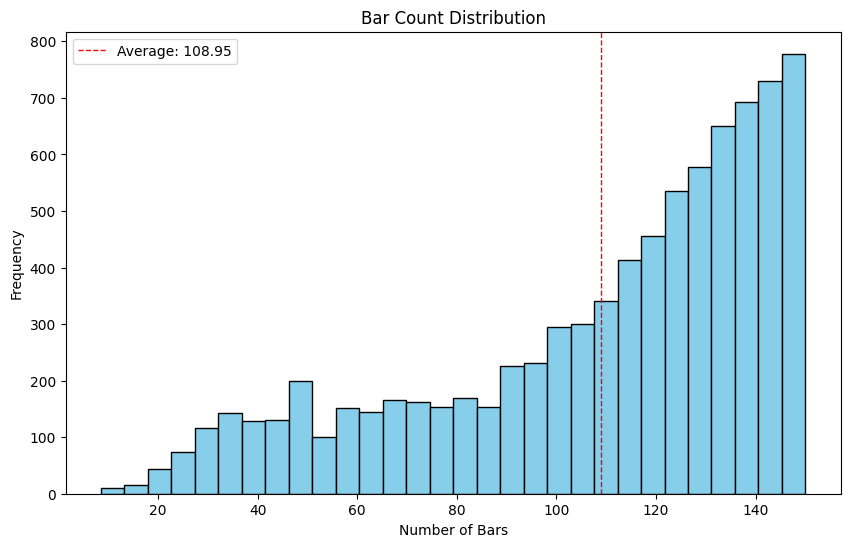

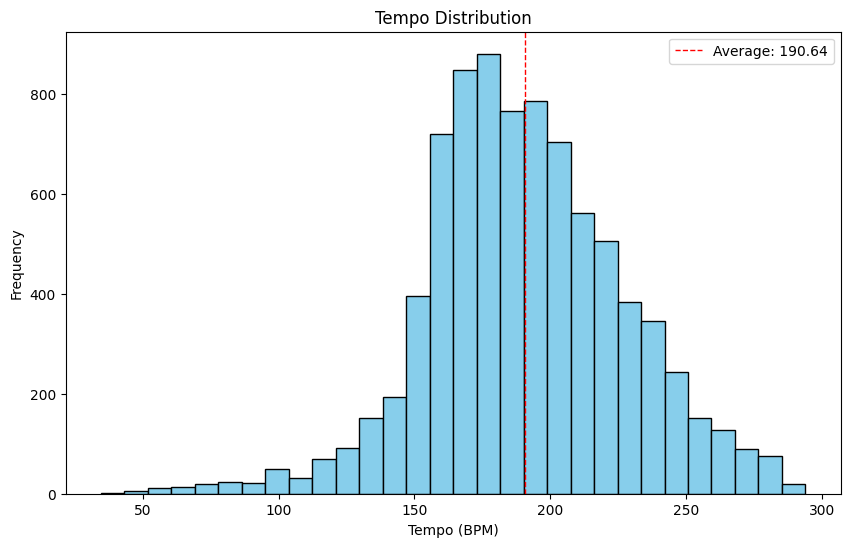

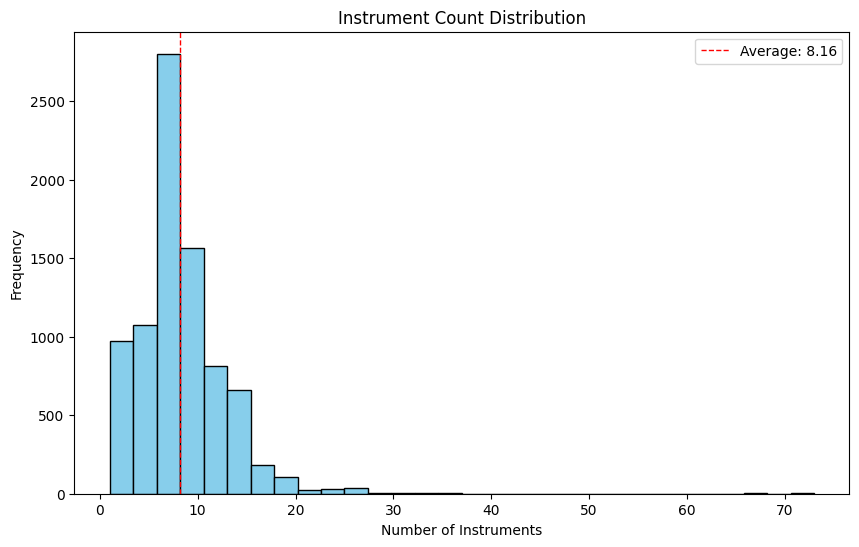

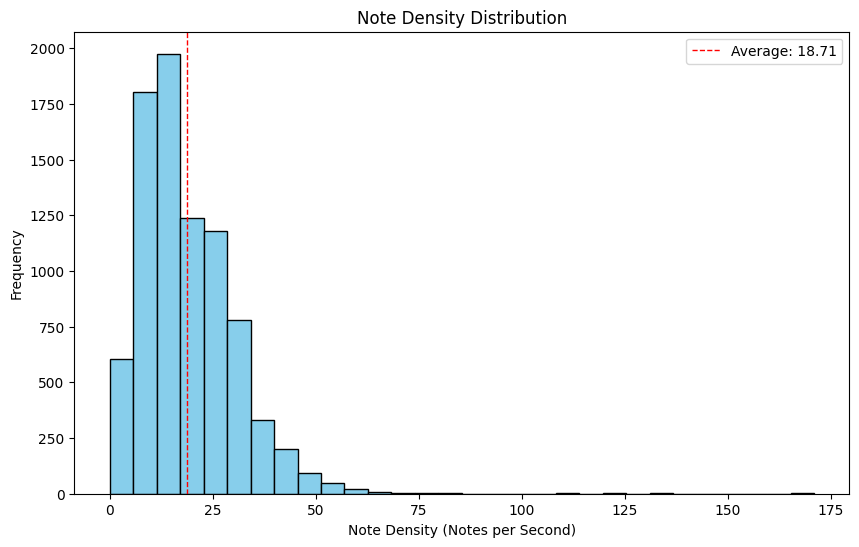

In [ ]:
def plot_histogram(data, title, xlabel, ylabel, average):
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=30, color='skyblue', edgecolor='black')
    plt.axvline(average, color='r', linestyle='dashed', linewidth=1, label=f'Average: {average:.2f}')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

# Calculate the average for bar counts
avg_bars = sum(k * v for k, v in bar_counts.items()) / sum(bar_counts.values())
# Convert dictionary to a list for histogram
bar_list = [k for k, v in bar_counts.items() for _ in range(v)]
plot_histogram(bar_list, 'Bar Count Distribution', 'Number of Bars', 'Frequency', avg_bars)

# Calculate the average for tempo
avg_tempo = sum(k * v for k, v in tempo_counts.items()) / sum(tempo_counts.values())
# Convert dictionary to a list for histogram
tempo_list = [k for k, v in tempo_counts.items() for _ in range(v)]
plot_histogram(tempo_list, 'Tempo Distribution', 'Tempo (BPM)', 'Frequency', avg_tempo)

# Calculate the average for instrument count
avg_instruments = sum(k * v for k, v in instrument_count.items()) / sum(instrument_count.values())
# Convert dictionary to a list for histogram
instrument_list = [k for k, v in instrument_count.items() for _ in range(v)]
plot_histogram(instrument_list, 'Instrument Count Distribution', 'Number of Instruments', 'Frequency', avg_instruments)

# Calculate the average note density
avg_density = sum(k * v for k, v in density_count.items()) / sum(density_count.values())
density_list = [k for k, v in density_count.items() for _ in range(v)]
plot_histogram(density_list, 'Note Density Distribution', 'Note Density (Notes per Second)', 'Frequency', avg_density)


# Pre-processing

### Create tokenizers

In [ ]:
# Create the tokenizers

# Our parameters
TOKENIZER_PARAMS = {
    "pitch_range": (21, 109),
    "beat_res": {(0, 4): 8, (4, 12): 4},
    "num_velocities": 32,
    "special_tokens": ["PAD", "BOS", "EOS", "MASK"],
    "use_chords": True,
    "use_rests": True,
    "use_tempos": True,
    "use_time_signatures": True,
    "use_programs": True,
    "num_tempos": 32,  # nb of tempo bins
    "tempo_range": (40, 250),  # (min, max)
    "max_bar_embedding": 500,
    "drum_pitch_range": (0, 127),
}
config = TokenizerConfig(**TOKENIZER_PARAMS)

# Creates the tokenizer
REMI_tokenizer = REMI(config)
#REMIP_tokenizer = REMIPlus(config)
#Octu_tokenizer = Octuple(config)
#MM_tokenizer = MuMIDI(config)

In [ ]:
REMI_tokenizer.vocab

{'PAD_None': 0,
 'BOS_None': 1,
 'EOS_None': 2,
 'MASK_None': 3,
 'Bar_0': 4,
 'Bar_1': 5,
 'Bar_2': 6,
 'Bar_3': 7,
 'Bar_4': 8,
 'Bar_5': 9,
 'Bar_6': 10,
 'Bar_7': 11,
 'Bar_8': 12,
 'Bar_9': 13,
 'Bar_10': 14,
 'Bar_11': 15,
 'Bar_12': 16,
 'Bar_13': 17,
 'Bar_14': 18,
 'Bar_15': 19,
 'Bar_16': 20,
 'Bar_17': 21,
 'Bar_18': 22,
 'Bar_19': 23,
 'Bar_20': 24,
 'Bar_21': 25,
 'Bar_22': 26,
 'Bar_23': 27,
 'Bar_24': 28,
 'Bar_25': 29,
 'Bar_26': 30,
 'Bar_27': 31,
 'Bar_28': 32,
 'Bar_29': 33,
 'Bar_30': 34,
 'Bar_31': 35,
 'Bar_32': 36,
 'Bar_33': 37,
 'Bar_34': 38,
 'Bar_35': 39,
 'Bar_36': 40,
 'Bar_37': 41,
 'Bar_38': 42,
 'Bar_39': 43,
 'Bar_40': 44,
 'Bar_41': 45,
 'Bar_42': 46,
 'Bar_43': 47,
 'Bar_44': 48,
 'Bar_45': 49,
 'Bar_46': 50,
 'Bar_47': 51,
 'Bar_48': 52,
 'Bar_49': 53,
 'Bar_50': 54,
 'Bar_51': 55,
 'Bar_52': 56,
 'Bar_53': 57,
 'Bar_54': 58,
 'Bar_55': 59,
 'Bar_56': 60,
 'Bar_57': 61,
 'Bar_58': 62,
 'Bar_59': 63,
 'Bar_60': 64,
 'Bar_61': 65,
 'Bar_62': 66,
 'Bar_

### Create REMI tokens from midi data

In [ ]:
#Convert midi to REMI tokens, store in directory
source_directory = r'G:\FYP\Lahk_Matched\MIDI_folder\bar_midis_larger' # Source directory with MIDI files
tokens_path = Path(r'G:\FYP\Lahk_Matched\REMI_folder\REMI_tokens_larger')  # Destination directory for tokens

midi_paths = list(Path(source_directory).glob('**/*.mid')) + list(Path(source_directory).glob('**/*.midi'))
REMI_tokenizer.tokenize_midi_dataset(midi_paths, tokens_path)


Tokenizing MIDIs (REMI_folder/REMI_tokens_larger): 100%|██████████| 8290/8290 [27:32<00:00,  5.02it/s]


### Learn and apply BPE (Byte Pair Encoding) to REMI tokens

In [ ]:
remi_tokens_path = Path('G:\FYP\Lahk_Matched\REMI_folder\REMI_tokens_larger')
remi_bpe_path = 'G:\FYP\Lahk_Matched\REMI_folder\REMI_BPE_larger'

REMI_tokenizer.learn_bpe(
    vocab_size=25000,
    tokens_paths=list(remi_tokens_path.glob("**/*.json")),
    start_from_empty_voc=False,
)
REMI_tokenizer.save_params("remi_tokenizer_bpe.config")
REMI_tokenizer.apply_bpe_to_dataset(
    remi_tokens_path,
    remi_bpe_path
)

Applying BPE to dataset: 100%|██████████| 8270/8270 [02:51<00:00, 48.09it/s]


In [ ]:
# Load config file for tokenizer
config_path = Path('G:/FYP/Lahk_Matched/REMI_folder/remi_tokenizer_bpe.config')
# Load the configuration
with open(config_path, 'r') as config_file:
    remi_params = json.load(config_file)

remi_config = TokenizerConfig(**remi_params)
REMI_tokenizer = REMI(remi_config)


### Now we have BPE of REMI we can split into training, validation  and test set

In [ ]:
remi_bpe_path = 'G:\FYP\Lahk_Matched\REMI_folder\REMI_BPE_larger'


In [ ]:
remi_bpe_path = Path(remi_bpe_path)

REMI_paths = list(remi_bpe_path.glob('**/*.json'))


In [ ]:
# Split to train and test sets
total_num_files = len(REMI_paths)
num_files_valid = round(total_num_files * 0.2)
num_files_test = 25
shuffle(REMI_paths)

remi_paths_valid = REMI_paths[:num_files_valid]
remi_paths_test = REMI_paths[num_files_valid:num_files_valid + num_files_test]
remi_paths_train = REMI_paths[num_files_valid + num_files_test:]


In [ ]:
REMIargs_dataset = {"min_seq_len": 256, "max_seq_len": 2052, "tokenizer": REMI_tokenizer}
#REMIPargs_dataset = {"min_seq_len": 256, "max_seq_len": 2052, "tokenizer": REMIP_tokenizer}

remi_dataset_train = DatasetTok(remi_paths_train, **REMIargs_dataset)
remi_dataset_valid = DatasetTok(remi_paths_valid, **REMIargs_dataset)
remi_dataset_test = DatasetTok(remi_paths_test, **REMIargs_dataset)
# Collator auto pads data for me
remi_collator = DataCollator(
    REMI_tokenizer["PAD_None"],
    REMI_tokenizer["BOS_None"],
    REMI_tokenizer["EOS_None"],
    pad_on_left=False,
    copy_inputs_as_labels=True,
    shift_labels=False,
    labels_pad_idx=-100 # This is the padding id for hugging face transformers.
    )


Loading data: G:\FYP\Lahk_Matched\REMI_folder\REMI_BPE_larger: 100%|██████████| 6591/6591 [00:50<00:00, 131.42it/s]
Loading data: G:\FYP\Lahk_Matched\REMI_folder\REMI_BPE_larger: 100%|██████████| 1654/1654 [00:12<00:00, 134.95it/s]
Loading data: G:\FYP\Lahk_Matched\REMI_folder\REMI_BPE_larger: 100%|██████████| 25/25 [00:00<00:00, 122.86it/s]


### I need to pad the inputs to a uniform length to correct attention mask ***MAY NOT NEED***

In [ ]:
# Initialize max_length to 0
max_length = 0

# Iterate over each dictionary in the list
for data_point in remi_dataset_train:
  # Check if the current dictionary has an 'input_ids' key
  if 'input_ids' in data_point:
      # Update max_length if necessary
      max_length = max(max_length, len(data_point['input_ids']))

print(max_length)
# Function for padding or truncating input data ids with the tokeniser pad id
def pad_data(input_data, is_input, length):
    pad_token_id = 0 if is_input else -100  # 0 for input data, -100 for label data

    for data_p in input_data:
        if 'input_ids' in data_p:
            seq = data_p['input_ids']
            num_pad = length-len(seq)

            if num_pad > 0:
                data_p['input_ids'] = seq + [pad_token_id] * num_pad
            elif num_pad < 0:
                data_p['input_ids'] = seq[:length]

2052


### Initialise and define
With help from  https://github.com/Natooz/MidiTok/blob/main/colab-notebooks/Example_HuggingFace_Mistral_Transformer.ipynb

In [ ]:
model_config= MistralConfig(
    vocab_size=len(REMI_tokenizer),
    hidden_size=256,
    intermediate_size=1024,
    num_hidden_layers=6,
    num_attention_heads=4,
    num_key_value_heads=2,
    sliding_window=256,
    max_position_embeddings=8192,
    pad_token_id=REMI_tokenizer['PAD_None'],
    bos_token_id=REMI_tokenizer['BOS_None'],
    eos_token_id=REMI_tokenizer['EOS_None']
)


In [ ]:
remi_model = AutoModelForCausalLM.from_config(model_config)

In [ ]:
metrics = {metric: load_metric(metric) for metric in ["accuracy"]}

def compute_metrics(eval_pred):
    """
    Compute metrics for pretraining.

    Must use preprocess_logits function that converts logits to predictions (argmax or sampling).

    :param eval_pred: EvalPrediction containing predictions and labels
    :return: metrics
    """
    predictions, labels = eval_pred
    not_pad_mask = labels != -100
    labels, predictions = labels[not_pad_mask], predictions[not_pad_mask]
    return metrics["accuracy"].compute(predictions=predictions.flatten(), references=labels.flatten())

def preprocess_logits(logits: Tensor, _: Tensor) -> Tensor:
    """
    Preprocess the logits before accumulating them during evaluation.

    This allows to significantly reduce the memory usage and make the training tractable.
    """
    pred_ids = argmax(logits, dim=-1)  # long dtype
    return pred_ids

In [ ]:
# Create config for the Trainer
USE_CUDA = cuda_available()
if not cuda_available():
    FP16 = FP16_EVAL = BF16 = BF16_EVAL = False
elif is_bf16_supported():
    BF16 = BF16_EVAL = True
    FP16 = FP16_EVAL = False
else:
    BF16 = BF16_EVAL = False
    FP16 = FP16_EVAL = True
USE_MPS = not USE_CUDA and mps_available()

training_config = TrainingArguments(
    "G:\FYP\mod_100",
    False,
    True,
    True,
    False,
    "epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    eval_accumulation_steps=None,
    eval_steps=10,
    learning_rate=1e-4,
    weight_decay=0.01,
    max_grad_norm=3.0,
    num_train_epochs=100,
    #max_steps=2000,
    lr_scheduler_type="cosine_with_restarts",
    warmup_ratio=0.3,
    logging_dir= "G:\FYP\logs_100",
    logging_first_step=True,
    log_level="debug",
    logging_strategy="epoch",
    logging_steps=10,
    save_strategy="epoch",
    save_total_limit=10,
    save_steps=10,
    no_cuda=not USE_CUDA,
    seed=42,
    fp16=FP16,
    fp16_full_eval=FP16_EVAL,
    bf16=BF16,
    bf16_full_eval=BF16_EVAL,
    load_best_model_at_end=True,
    label_smoothing_factor=0.,
    optim="adamw_torch",
    report_to=["tensorboard"],
    gradient_checkpointing=False,
    disable_tqdm=True,
    dataloader_num_workers=4
)


In [ ]:
#Trainer does this for you
train_data_loaded = DataLoader(remi_dataset_train, batch_size=32, shuffle=True, num_workers=4)
test_data_loaded = DataLoader(remi_dataset_test, batch_size=32, shuffle=True, num_workers=4)
test_data_valid = DataLoader(remi_dataset_valid, batch_size=32, shuffle=True, num_workers=4)

In [ ]:
remi_model = AutoModelForCausalLM.from_pretrained(r"G:\FYP\Cps\checkpoint-10")

In [ ]:
print(remi_model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(25000, 512, padding_idx=0)
    (layers): ModuleList(
      (0-7): 8 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear(in_features=512, out_features=512, bias=False)
          (k_proj): Linear(in_features=512, out_features=256, bias=False)
          (v_proj): Linear(in_features=512, out_features=256, bias=False)
          (o_proj): Linear(in_features=512, out_features=512, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear(in_features=512, out_features=2048, bias=False)
          (up_proj): Linear(in_features=512, out_features=2048, bias=False)
          (down_proj): Linear(in_features=2048, out_features=512, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
    (norm): MistralRMSNorm()
  )


In [ ]:
#remi_collator = DataCollator(REMI_tokenizer["PAD_None"], REMI_tokenizer["BOS_None"], REMI_tokenizer["EOS_None"], copy_inputs_as_labels=True)
remi_trainer = Trainer(
    model=remi_model,
    args=training_config,
    data_collator=remi_collator,
    train_dataset=remi_dataset_train,
    eval_dataset=remi_dataset_valid,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=10)],
    preprocess_logits_for_metrics=preprocess_logits,
)

# Training
print("Training commencing....")
train_result = remi_trainer.train()
print("Training complete.")
remi_trainer.save_model()  # Saves the tokenizer too
remi_trainer.log_metrics("train", train_result.metrics)
remi_trainer.save_metrics("train", train_result.metrics)
remi_trainer.save_state()

Using auto half precision backend
Currently training with a batch size of: 4
***** Running training *****
  Num examples = 16,381
  Num Epochs = 100
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 4
  Total optimization steps = 102,400
  Number of trainable parameters = 18,701,568


Training commencing....
{'loss': 10.1751, 'learning_rate': 3.2552083333333333e-09, 'epoch': 0.0}


***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 10.0893, 'learning_rate': 3.3333333333333333e-06, 'epoch': 1.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-1024
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-1024\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-1024\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-1024\model.safetensors


{'eval_loss': 9.884842872619629, 'eval_accuracy': 0.001860183125659834, 'eval_runtime': 122.43, 'eval_samples_per_second': 33.587, 'eval_steps_per_second': 8.397, 'epoch': 1.0}


***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 9.5866, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-2048
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-2048\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-2048\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-2048\model.safetensors


{'eval_loss': 9.290580749511719, 'eval_accuracy': 0.0054852488024712, 'eval_runtime': 123.0616, 'eval_samples_per_second': 33.414, 'eval_steps_per_second': 8.354, 'epoch': 2.0}


***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 9.0388, 'learning_rate': 1e-05, 'epoch': 3.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-3072
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-3072\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-3072\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-3072\model.safetensors


{'eval_loss': 8.881807327270508, 'eval_accuracy': 0.010821380235417646, 'eval_runtime': 124.0382, 'eval_samples_per_second': 33.151, 'eval_steps_per_second': 8.288, 'epoch': 3.0}


***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 8.7646, 'learning_rate': 1.3333333333333333e-05, 'epoch': 4.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-4096
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-4096\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-4096\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-4096\model.safetensors


{'eval_loss': 8.710929870605469, 'eval_accuracy': 0.020435105984749947, 'eval_runtime': 122.9833, 'eval_samples_per_second': 33.435, 'eval_steps_per_second': 8.359, 'epoch': 4.0}


***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 8.5828, 'learning_rate': 1.6666666666666667e-05, 'epoch': 5.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-5120
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-5120\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-5120\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-5120\model.safetensors


{'eval_loss': 8.524188041687012, 'eval_accuracy': 0.03799045284450492, 'eval_runtime': 122.689, 'eval_samples_per_second': 33.516, 'eval_steps_per_second': 8.379, 'epoch': 5.0}


***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 8.2871, 'learning_rate': 2e-05, 'epoch': 6.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-6144
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-6144\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-6144\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-6144\model.safetensors


{'eval_loss': 8.071983337402344, 'eval_accuracy': 0.021015598601828455, 'eval_runtime': 123.3203, 'eval_samples_per_second': 33.344, 'eval_steps_per_second': 8.336, 'epoch': 6.0}


***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 7.6575, 'learning_rate': 2.3333333333333336e-05, 'epoch': 7.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-7168
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-7168\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-7168\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-7168\model.safetensors


{'eval_loss': 7.44247579574585, 'eval_accuracy': 0.0019762255899140597, 'eval_runtime': 123.1218, 'eval_samples_per_second': 33.398, 'eval_steps_per_second': 8.349, 'epoch': 7.0}


***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 7.0965, 'learning_rate': 2.6663411458333336e-05, 'epoch': 8.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-8192
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-8192\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-8192\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-8192\model.safetensors


{'eval_loss': 7.006322860717773, 'eval_accuracy': 0.00047916568271159286, 'eval_runtime': 123.4731, 'eval_samples_per_second': 33.303, 'eval_steps_per_second': 8.326, 'epoch': 8.0}


***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 6.6662, 'learning_rate': 2.999674479166667e-05, 'epoch': 9.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-9216
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-9216\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-9216\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-9216\model.safetensors


{'eval_loss': 6.6621294021606445, 'eval_accuracy': 0.00019844943162316918, 'eval_runtime': 123.1801, 'eval_samples_per_second': 33.382, 'eval_steps_per_second': 8.346, 'epoch': 9.0}


***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 6.2918, 'learning_rate': 3.3330078125e-05, 'epoch': 10.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-10240
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-10240\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-10240\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-10240\model.safetensors


{'eval_loss': 6.367221832275391, 'eval_accuracy': 0.00026740220023799917, 'eval_runtime': 122.9078, 'eval_samples_per_second': 33.456, 'eval_steps_per_second': 8.364, 'epoch': 10.0}


***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 5.9486, 'learning_rate': 3.666015625e-05, 'epoch': 11.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-11264
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-11264\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-11264\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-11264\model.safetensors


{'eval_loss': 6.106447696685791, 'eval_accuracy': 0.0003327111233569235, 'eval_runtime': 122.9116, 'eval_samples_per_second': 33.455, 'eval_steps_per_second': 8.364, 'epoch': 11.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-1024] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 5.6277, 'learning_rate': 3.9993489583333335e-05, 'epoch': 12.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-12288
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-12288\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-12288\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-12288\model.safetensors


{'eval_loss': 5.872970104217529, 'eval_accuracy': 0.00041105380151889497, 'eval_runtime': 123.1164, 'eval_samples_per_second': 33.399, 'eval_steps_per_second': 8.35, 'epoch': 12.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-2048] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 5.3264, 'learning_rate': 4.3320312500000004e-05, 'epoch': 13.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-13312
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-13312\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-13312\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-13312\model.safetensors


{'eval_loss': 5.672508716583252, 'eval_accuracy': 0.00047860509109683814, 'eval_runtime': 127.5087, 'eval_samples_per_second': 32.249, 'eval_steps_per_second': 8.062, 'epoch': 13.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-3072] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 5.0452, 'learning_rate': 4.6653645833333334e-05, 'epoch': 14.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-14336
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-14336\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-14336\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-14336\model.safetensors


{'eval_loss': 5.479847431182861, 'eval_accuracy': 0.0004473521085742628, 'eval_runtime': 122.5764, 'eval_samples_per_second': 33.546, 'eval_steps_per_second': 8.387, 'epoch': 14.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-4096] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 4.7806, 'learning_rate': 4.998372395833333e-05, 'epoch': 15.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-15360
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-15360\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-15360\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-15360\model.safetensors


{'eval_loss': 5.307281017303467, 'eval_accuracy': 0.0004636092654021495, 'eval_runtime': 123.2442, 'eval_samples_per_second': 33.365, 'eval_steps_per_second': 8.341, 'epoch': 15.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-5120] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 4.529, 'learning_rate': 5.3317057291666675e-05, 'epoch': 16.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-16384
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-16384\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-16384\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-16384\model.safetensors


{'eval_loss': 5.151515483856201, 'eval_accuracy': 0.0002909470480576972, 'eval_runtime': 123.2259, 'eval_samples_per_second': 33.37, 'eval_steps_per_second': 8.342, 'epoch': 16.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-6144] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 4.2918, 'learning_rate': 5.6650390625000006e-05, 'epoch': 17.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-17408
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-17408\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-17408\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-17408\model.safetensors


{'eval_loss': 5.002993106842041, 'eval_accuracy': 0.0002756709265556312, 'eval_runtime': 123.2337, 'eval_samples_per_second': 33.367, 'eval_steps_per_second': 8.342, 'epoch': 17.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-7168] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 4.0693, 'learning_rate': 5.998372395833334e-05, 'epoch': 18.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-18432
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-18432\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-18432\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-18432\model.safetensors


{'eval_loss': 4.877673149108887, 'eval_accuracy': 0.00026768249604537653, 'eval_runtime': 123.0393, 'eval_samples_per_second': 33.42, 'eval_steps_per_second': 8.355, 'epoch': 18.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-8192] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 3.8568, 'learning_rate': 6.331380208333334e-05, 'epoch': 19.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-19456
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-19456\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-19456\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-19456\model.safetensors


{'eval_loss': 4.737063407897949, 'eval_accuracy': 0.00020279401663751825, 'eval_runtime': 122.8317, 'eval_samples_per_second': 33.477, 'eval_steps_per_second': 8.369, 'epoch': 19.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-9216] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 3.6562, 'learning_rate': 6.664713541666668e-05, 'epoch': 20.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-20480
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-20480\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-20480\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-20480\model.safetensors


{'eval_loss': 4.611846923828125, 'eval_accuracy': 0.00015304151082803726, 'eval_runtime': 123.4956, 'eval_samples_per_second': 33.297, 'eval_steps_per_second': 8.324, 'epoch': 20.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-10240] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 3.4719, 'learning_rate': 6.997721354166667e-05, 'epoch': 21.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-21504
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-21504\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-21504\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-21504\model.safetensors


{'eval_loss': 4.507663249969482, 'eval_accuracy': 0.00014014790368867882, 'eval_runtime': 122.4631, 'eval_samples_per_second': 33.577, 'eval_steps_per_second': 8.394, 'epoch': 21.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-11264] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 3.3058, 'learning_rate': 7.331054687500001e-05, 'epoch': 22.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-22528
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-22528\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-22528\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-22528\model.safetensors


{'eval_loss': 4.423434257507324, 'eval_accuracy': 0.00012865577558620714, 'eval_runtime': 123.2399, 'eval_samples_per_second': 33.366, 'eval_steps_per_second': 8.341, 'epoch': 22.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-12288] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 3.1571, 'learning_rate': 7.664388020833334e-05, 'epoch': 23.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-23552
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-23552\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-23552\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-23552\model.safetensors


{'eval_loss': 4.324807643890381, 'eval_accuracy': 0.00013706464980752788, 'eval_runtime': 123.1751, 'eval_samples_per_second': 33.383, 'eval_steps_per_second': 8.346, 'epoch': 23.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-13312] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 3.0264, 'learning_rate': 7.997721354166667e-05, 'epoch': 24.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-24576
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-24576\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-24576\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-24576\model.safetensors


{'eval_loss': 4.267261981964111, 'eval_accuracy': 0.0001224892678239053, 'eval_runtime': 123.4611, 'eval_samples_per_second': 33.306, 'eval_steps_per_second': 8.327, 'epoch': 24.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-14336] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 2.9109, 'learning_rate': 8.330729166666667e-05, 'epoch': 25.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-25600
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-25600\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-25600\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-25600\model.safetensors


{'eval_loss': 4.203242301940918, 'eval_accuracy': 0.00010623211099601854, 'eval_runtime': 123.9789, 'eval_samples_per_second': 33.167, 'eval_steps_per_second': 8.292, 'epoch': 25.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-15360] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 2.8047, 'learning_rate': 8.664062500000001e-05, 'epoch': 26.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-26624
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-26624\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-26624\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-26624\model.safetensors


{'eval_loss': 4.155553817749023, 'eval_accuracy': 0.00013454198754113164, 'eval_runtime': 122.8855, 'eval_samples_per_second': 33.462, 'eval_steps_per_second': 8.366, 'epoch': 26.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-16384] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 2.7077, 'learning_rate': 8.9970703125e-05, 'epoch': 27.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-27648
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-27648\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-27648\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-27648\model.safetensors


{'eval_loss': 4.096980571746826, 'eval_accuracy': 0.0001229097115349713, 'eval_runtime': 123.705, 'eval_samples_per_second': 33.24, 'eval_steps_per_second': 8.31, 'epoch': 27.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-17408] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 2.6199, 'learning_rate': 9.330403645833333e-05, 'epoch': 28.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-28672
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-28672\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-28672\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-28672\model.safetensors


{'eval_loss': 4.072983264923096, 'eval_accuracy': 0.00012473163428292414, 'eval_runtime': 123.2601, 'eval_samples_per_second': 33.36, 'eval_steps_per_second': 8.34, 'epoch': 28.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-18432] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 2.5386, 'learning_rate': 9.663411458333334e-05, 'epoch': 29.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-29696
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-29696\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-29696\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-29696\model.safetensors


{'eval_loss': 4.039902687072754, 'eval_accuracy': 0.0001275345923566977, 'eval_runtime': 123.3082, 'eval_samples_per_second': 33.347, 'eval_steps_per_second': 8.337, 'epoch': 29.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-19456] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 2.4632, 'learning_rate': 9.996744791666666e-05, 'epoch': 30.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-30720
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-30720\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-30720\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-30720\model.safetensors


{'eval_loss': 4.0019145011901855, 'eval_accuracy': 0.00011940601394275434, 'eval_runtime': 122.5196, 'eval_samples_per_second': 33.562, 'eval_steps_per_second': 8.39, 'epoch': 30.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-20480] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 2.3898, 'learning_rate': 9.99507290074029e-05, 'epoch': 31.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-31744
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-31744\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-31744\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-31744\model.safetensors


{'eval_loss': 3.969301223754883, 'eval_accuracy': 0.00011001610439561287, 'eval_runtime': 122.3468, 'eval_samples_per_second': 33.609, 'eval_steps_per_second': 8.402, 'epoch': 31.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-21504] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 2.3158, 'learning_rate': 9.980086970486817e-05, 'epoch': 32.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-32768
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-32768\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-32768\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-32768\model.safetensors


{'eval_loss': 3.9226627349853516, 'eval_accuracy': 0.00010034589904109403, 'eval_runtime': 122.0474, 'eval_samples_per_second': 33.692, 'eval_steps_per_second': 8.423, 'epoch': 32.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-22528] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 2.2473, 'learning_rate': 9.955101114275218e-05, 'epoch': 33.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-33792
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-33792\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-33792\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-33792\model.safetensors


{'eval_loss': 3.935548782348633, 'eval_accuracy': 0.00010497077986282043, 'eval_runtime': 122.3288, 'eval_samples_per_second': 33.614, 'eval_steps_per_second': 8.404, 'epoch': 33.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-23552] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 2.1816, 'learning_rate': 9.92011681029845e-05, 'epoch': 34.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-34816
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-34816\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-34816\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-34816\model.safetensors


{'eval_loss': 3.90629243850708, 'eval_accuracy': 0.00012108778878701849, 'eval_runtime': 121.9701, 'eval_samples_per_second': 33.713, 'eval_steps_per_second': 8.428, 'epoch': 34.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-24576] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 2.1235, 'learning_rate': 9.875272692057102e-05, 'epoch': 35.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-35840
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-35840\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-35840\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-35840\model.safetensors


{'eval_loss': 3.9022157192230225, 'eval_accuracy': 0.00011113728762512229, 'eval_runtime': 122.5742, 'eval_samples_per_second': 33.547, 'eval_steps_per_second': 8.387, 'epoch': 35.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-25600] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 2.0732, 'learning_rate': 9.820629586928749e-05, 'epoch': 36.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-36864
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-36864\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-36864\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-36864\model.safetensors


{'eval_loss': 3.8999977111816406, 'eval_accuracy': 0.00011085699181774494, 'eval_runtime': 123.5275, 'eval_samples_per_second': 33.288, 'eval_steps_per_second': 8.322, 'epoch': 36.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-26624] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 2.0242, 'learning_rate': 9.756229738509993e-05, 'epoch': 37.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-37888
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-37888\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-37888\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-37888\model.safetensors


{'eval_loss': 3.9048912525177, 'eval_accuracy': 0.00012094764088332981, 'eval_runtime': 122.4694, 'eval_samples_per_second': 33.576, 'eval_steps_per_second': 8.394, 'epoch': 37.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-27648] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 1.9772, 'learning_rate': 9.682251476369437e-05, 'epoch': 38.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-38912
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-38912\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-38912\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-38912\model.safetensors


{'eval_loss': 3.8952977657318115, 'eval_accuracy': 0.0001138000977952072, 'eval_runtime': 122.3931, 'eval_samples_per_second': 33.597, 'eval_steps_per_second': 8.399, 'epoch': 38.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-28672] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 1.9365, 'learning_rate': 9.598843782881811e-05, 'epoch': 39.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-39936
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-39936\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-39936\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-39936\model.safetensors


{'eval_loss': 3.8812451362609863, 'eval_accuracy': 0.00012473163428292414, 'eval_runtime': 121.7514, 'eval_samples_per_second': 33.774, 'eval_steps_per_second': 8.443, 'epoch': 39.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-29696] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 1.8971, 'learning_rate': 9.506269585880545e-05, 'epoch': 40.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-40960
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-40960\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-40960\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-40960\model.safetensors


{'eval_loss': 3.8675425052642822, 'eval_accuracy': 0.00012879592348989582, 'eval_runtime': 122.3064, 'eval_samples_per_second': 33.62, 'eval_steps_per_second': 8.405, 'epoch': 40.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-30720] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 1.8586, 'learning_rate': 9.404534362165206e-05, 'epoch': 41.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-41984
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-41984\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-41984\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-41984\model.safetensors


{'eval_loss': 3.880139112472534, 'eval_accuracy': 0.00011001610439561287, 'eval_runtime': 122.2105, 'eval_samples_per_second': 33.647, 'eval_steps_per_second': 8.412, 'epoch': 41.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-31744] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 1.8212, 'learning_rate': 9.294041261394165e-05, 'epoch': 42.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-43008
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-43008\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-43008\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-43008\model.safetensors


{'eval_loss': 3.869847536087036, 'eval_accuracy': 0.00010987595649192419, 'eval_runtime': 121.7831, 'eval_samples_per_second': 33.765, 'eval_steps_per_second': 8.441, 'epoch': 42.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-32768] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 1.7891, 'learning_rate': 9.174796820470639e-05, 'epoch': 43.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-44032
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-44032\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-44032\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-44032\model.safetensors


{'eval_loss': 3.8713173866271973, 'eval_accuracy': 0.00011688335167635813, 'eval_runtime': 122.5621, 'eval_samples_per_second': 33.55, 'eval_steps_per_second': 8.388, 'epoch': 43.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-33792] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 1.7601, 'learning_rate': 9.047273573428224e-05, 'epoch': 44.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-45056
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-45056\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-45056\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-45056\model.safetensors


{'eval_loss': 3.8602049350738525, 'eval_accuracy': 0.00012949666300833922, 'eval_runtime': 122.1517, 'eval_samples_per_second': 33.663, 'eval_steps_per_second': 8.416, 'epoch': 44.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-34816] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 1.7301, 'learning_rate': 8.911479064693841e-05, 'epoch': 45.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-46080
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-46080\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-46080\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-46080\model.safetensors


{'eval_loss': 3.8968753814697266, 'eval_accuracy': 0.00011015625229930155, 'eval_runtime': 123.2128, 'eval_samples_per_second': 33.373, 'eval_steps_per_second': 8.343, 'epoch': 45.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-35840] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 1.6997, 'learning_rate': 8.767951411822113e-05, 'epoch': 46.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-47104
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-47104\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-47104\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-47104\model.safetensors


{'eval_loss': 3.8790884017944336, 'eval_accuracy': 0.00011141758343249965, 'eval_runtime': 121.9404, 'eval_samples_per_second': 33.721, 'eval_steps_per_second': 8.43, 'epoch': 46.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-36864] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 1.6734, 'learning_rate': 8.616699106079642e-05, 'epoch': 47.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-48128
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-48128\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-48128\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-48128\model.safetensors


{'eval_loss': 3.9243860244750977, 'eval_accuracy': 0.00011786438700217887, 'eval_runtime': 122.3479, 'eval_samples_per_second': 33.609, 'eval_steps_per_second': 8.402, 'epoch': 47.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-37888] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 1.6463, 'learning_rate': 8.458321520163128e-05, 'epoch': 48.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-49152
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-49152\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-49152\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-49152\model.safetensors


{'eval_loss': 3.9210739135742188, 'eval_accuracy': 0.00011492128102471662, 'eval_runtime': 122.2569, 'eval_samples_per_second': 33.634, 'eval_steps_per_second': 8.409, 'epoch': 48.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-38912] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 1.6191, 'learning_rate': 8.292828023878865e-05, 'epoch': 49.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-50176
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-50176\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-50176\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-50176\model.safetensors


{'eval_loss': 3.9370481967926025, 'eval_accuracy': 0.00010861462535872608, 'eval_runtime': 122.5298, 'eval_samples_per_second': 33.559, 'eval_steps_per_second': 8.39, 'epoch': 49.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-39936] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 1.5973, 'learning_rate': 8.120874423977487e-05, 'epoch': 50.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-51200
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-51200\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-51200\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-51200\model.safetensors


{'eval_loss': 3.941155195236206, 'eval_accuracy': 0.00011141758343249965, 'eval_runtime': 126.8683, 'eval_samples_per_second': 32.412, 'eval_steps_per_second': 8.103, 'epoch': 50.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-40960] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 1.571, 'learning_rate': 7.942470893438416e-05, 'epoch': 51.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-52224
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-52224\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-52224\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-52224\model.safetensors


{'eval_loss': 3.9771976470947266, 'eval_accuracy': 0.00011940601394275434, 'eval_runtime': 129.6345, 'eval_samples_per_second': 31.72, 'eval_steps_per_second': 7.93, 'epoch': 51.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-41984] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 1.5506, 'learning_rate': 7.758324398047565e-05, 'epoch': 52.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-53248
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-53248\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-53248\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-53248\model.safetensors


{'eval_loss': 3.9802322387695312, 'eval_accuracy': 0.00012094764088332981, 'eval_runtime': 121.4745, 'eval_samples_per_second': 33.851, 'eval_steps_per_second': 8.463, 'epoch': 52.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-43008] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 1.5258, 'learning_rate': 7.568445832130552e-05, 'epoch': 53.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-54272
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-54272\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-54272\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-54272\model.safetensors


{'eval_loss': 4.020113945007324, 'eval_accuracy': 0.00011478113312102795, 'eval_runtime': 123.6253, 'eval_samples_per_second': 33.262, 'eval_steps_per_second': 8.315, 'epoch': 53.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-44032] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4112
  Batch size = 4


{'loss': 1.5011, 'learning_rate': 7.373587633989335e-05, 'epoch': 54.0}


Saving model checkpoint to G:\FYP\mod_100\tmp-checkpoint-55296
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-55296\config.json
Configuration saved in G:\FYP\mod_100\tmp-checkpoint-55296\generation_config.json
Model weights saved in G:\FYP\mod_100\tmp-checkpoint-55296\model.safetensors


{'eval_loss': 4.052236080169678, 'eval_accuracy': 0.00010861462535872608, 'eval_runtime': 130.7376, 'eval_samples_per_second': 31.452, 'eval_steps_per_second': 7.863, 'epoch': 54.0}


Deleting older checkpoint [G:\FYP\mod_100\checkpoint-46080] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from G:\FYP\mod_100\checkpoint-45056 (score: 3.8602049350738525).
Saving model checkpoint to G:\FYP\mod_100
Configuration saved in G:\FYP\mod_100\config.json
Configuration saved in G:\FYP\mod_100\generation_config.json
Model weights saved in G:\FYP\mod_100\model.safetensors


{'train_runtime': 50622.149, 'train_samples_per_second': 32.359, 'train_steps_per_second': 2.023, 'train_loss': 3.753862510193829, 'epoch': 54.0}
Training complete.
***** train metrics *****
  epoch                    =        54.0
  train_loss               =      3.7539
  train_runtime            = 14:03:42.14
  train_samples_per_second =      32.359
  train_steps_per_second   =       2.023


In [ ]:
torch.cuda.empty_cache()

free, total = torch.cuda.mem_get_info()
print(free, total)

7506755584 8589606912


In [ ]:
remi_trainer.save_model("G:\\FYP\\Cps")

Saving model checkpoint to G:\FYP\Cps
Configuration saved in G:\FYP\Cps\config.json
Configuration saved in G:\FYP\Cps\generation_config.json
Model weights saved in G:\FYP\Cps\model.safetensors


In [ ]:
remi_trainer.args

### Use trained model for generation

In [ ]:
(gen_results_path := Path('G:\FYP\mod_100\Gens2')).mkdir(parents=True, exist_ok=True)
generation_config = GenerationConfig(
    max_new_tokens=2058,  # extends samples by 512 tokens
    num_beams=1,        # no beam search
    do_sample=True,     # but sample instead
    temperature=0.9,
    top_k=15,
    top_p=0.95,
    epsilon_cutoff=3e-4,
    eta_cutoff=1e-3,
    pad_token_id=REMI_tokenizer.vocab.get('PAD_None'),
)

In [ ]:
remi_collator.pad_on_left = True
remi_collator.eos_token = None
dataloader_test = DataLoader(remi_dataset_test, batch_size=16, collate_fn=remi_collator)
remi_model.eval()

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(25000, 256, padding_idx=0)
    (layers): ModuleList(
      (0-5): 6 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear(in_features=256, out_features=256, bias=False)
          (k_proj): Linear(in_features=256, out_features=128, bias=False)
          (v_proj): Linear(in_features=256, out_features=128, bias=False)
          (o_proj): Linear(in_features=256, out_features=256, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear(in_features=256, out_features=1024, bias=False)
          (up_proj): Linear(in_features=256, out_features=1024, bias=False)
          (down_proj): Linear(in_features=1024, out_features=256, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
    (norm): MistralRMSNorm()
  )


In [ ]:
count = 0
for batch in tqdm(dataloader_test, desc='Testing model / Generating results'):
    res = remi_model.generate(
        inputs=batch["input_ids"].to(remi_model.device),
        attention_mask=batch["attention_mask"].to(remi_model.device),
        generation_config=generation_config)

    for continuation in res:
        generated = continuation[len(batch["input_ids"][0]):]  # Extract only the generated part
        midi = REMI_tokenizer.tokens_to_midi(deepcopy(generated.tolist()))

        # Check if any instruments were created
        if midi.instruments:
            # Set the name for the generated track
            midi.instruments[0].name = f'Generated music ({len(generated)} tokens)'

            # Save the MIDI file with only generated music
            midi.dump(gen_results_path / f'{count}.mid')
            count += 1
        else:
            print(f"No instruments generated for item {count}")


Testing model / Generating results:  25%|██▌       | 1/4 [00:35<01:47, 35.98s/it]

No instruments generated for item 5
No instruments generated for item 13


Testing model / Generating results:  75%|███████▌  | 3/4 [01:45<00:35, 35.05s/it]

No instruments generated for item 39
No instruments generated for item 40


Testing model / Generating results: 100%|██████████| 4/4 [02:17<00:00, 34.26s/it]

No instruments generated for item 51
